# Peptide Retention Time Prediction – Training Notebook

This notebook trains a Transformer-based model to predict peptide retention times from sequence, using the code in `src/rt_transformer.py`.

---

## 1. Setup & Imports

In [1]:
import sys
sys.path.append('./src')  # so we can import rt_transformer.py

from rt_transformer import AATokenizer, PeptideRTDataset, PeptideRTModel, split_dataset, collate, run_epoch, compute_metrics

import torch
from torch import nn
from torch.utils.data import DataLoader

import random
import numpy as np

## 2. Configuration
Set data path, model hyperparameters, and training settings.

In [2]:
DATA_PATH = "data/mouse.txt"  # path to your data file

# Model config
BATCH_SIZE = 64
EPOCHS = 60
LEARNING_RATE = 1e-4
D_MODEL = 128
N_HEADS = 8
N_QUERIES = 3
N_LAYERS = 10

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

Using device: cuda


## 3. Data Preparation
Load the dataset, split into train/validation, and create DataLoaders.

In [3]:
# Initialize tokenizer and dataset
tokenizer = AATokenizer()
dataset = PeptideRTDataset(DATA_PATH, tokenizer)

# Split into train/val
train_ds, val_ds = split_dataset(dataset, val_ratio=0.1, seed=SEED)

# DataLoaders
coll = lambda b: collate(b, tokenizer.pad_id)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=coll)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=coll)

print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}")

Train samples: 3068, Val samples: 340


## 4. Model Initialization
Create the Transformer model and optimizer.

In [4]:
model = PeptideRTModel(
    tokenizer,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=4*D_MODEL,
    n_layers=N_LAYERS,
    n_queries=N_QUERIES
)

if torch.cuda.is_available():
    model = nn.DataParallel(model)

model=model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.SmoothL1Loss()

## 5. Training Loop
Train the model and monitor loss.

In [5]:
train_losses, val_losses = [], []

for epoch in range(1, EPOCHS+1):
    train_loss = run_epoch(model, train_loader, loss_fn, optimizer, DEVICE)
    val_loss   = run_epoch(model, val_loader,   loss_fn, None, DEVICE)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch:3d} | train loss {train_loss:.6f} | val loss {val_loss:.6f}")

Epoch   1 | train loss 0.015778 | val loss 0.004364
Epoch   2 | train loss 0.004513 | val loss 0.002515
Epoch   3 | train loss 0.003215 | val loss 0.002300
Epoch   4 | train loss 0.003068 | val loss 0.001791
Epoch   5 | train loss 0.002785 | val loss 0.001654
Epoch   6 | train loss 0.002302 | val loss 0.001646
Epoch   7 | train loss 0.002137 | val loss 0.001669
Epoch   8 | train loss 0.002068 | val loss 0.001347
Epoch   9 | train loss 0.002052 | val loss 0.001821
Epoch  10 | train loss 0.001880 | val loss 0.001298
Epoch  11 | train loss 0.001823 | val loss 0.001558
Epoch  12 | train loss 0.001756 | val loss 0.001235
Epoch  13 | train loss 0.001842 | val loss 0.001264
Epoch  14 | train loss 0.001628 | val loss 0.001196
Epoch  15 | train loss 0.001685 | val loss 0.001479
Epoch  16 | train loss 0.001686 | val loss 0.001215
Epoch  17 | train loss 0.001652 | val loss 0.001468
Epoch  18 | train loss 0.001559 | val loss 0.001221
Epoch  19 | train loss 0.001575 | val loss 0.001131
Epoch  20 | 

## 6. Plot Training Curve

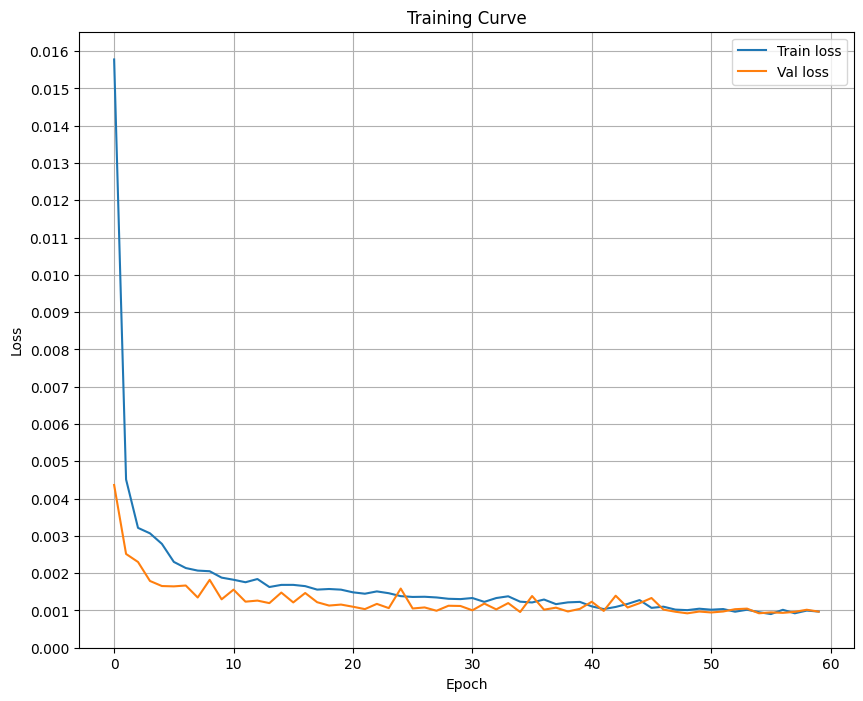

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
y_ticks = np.arange(0, max(max(train_losses), max(val_losses)) + 0.001, 0.001)
plt.yticks(y_ticks)
plt.legend()
plt.title('Training Curve')
plt.grid(True)
plt.show()

## 7. Save Model
Save the trained model weights for later evaluation.

In [7]:
MODEL_PATH = "rt_model.pt"
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to rt_model.pt


## 8. Compute Main Metrics for Trained Model

In [8]:
model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for seqs, mask, rts in val_loader:
        seqs, mask, rts = seqs.to(DEVICE), mask.to(DEVICE), rts.to(DEVICE)
        preds = model(seqs, mask)
        all_preds.append(preds.cpu())
        all_trues.append(rts.cpu())
all_preds = torch.cat(all_preds)
all_trues = torch.cat(all_trues)

metrics = compute_metrics(all_preds, all_trues)
print("\nValidation metrics for model:")
for k, v in metrics.items():
    print(f"{k:10s}: {v:.5f}")



Validation metrics for model:
MSE       : 0.00194
MAE       : 0.03213
R2        : 0.96529
Pearson   : 0.98275
Spearman  : 0.97673
